In [1]:
import pandas as pd
import bt
import matplotlib
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('TkAgg')
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')


In [2]:


# Now create a function that will allow us to generate related backtests more quickly
# This step is not required, but it is good programming practice
# I do not use these functions in this simple example, but they would be very useful
# if we were trying to pitimize our parameters
def above_sma(tickers, sma_per=50, start='2010-01-01', name='above_sma'):
    """
    Long securities that are above their n period
    Simple Moving Averages with equal weights.
    """
    # download data
    data = bt.get(tickers, start=start)
    # calc sma
    sma = data.rolling(sma_per).mean()

    # create strategy
    s = bt.Strategy(name, [bt.algos.SelectWhere(data > sma),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])

    # now we create the backtest
    return bt.Backtest(s, data)


In [3]:

# simple backtest to test long-only allocation
def long_only_ew(tickers, start='2010-01-01', name='long_only_ew'):
    s = bt.Strategy(name, [bt.algos.RunOnce(),
                           bt.algos.SelectAll(),
                           bt.algos.WeighEqually(),
                           bt.algos.Rebalance()])
    data = bt.get(tickers, start=start)
    return bt.Backtest(s, data)



In [4]:

# download data
data = bt.get('aapl,msft,c,gs,ge', start='2010-01-01')



In [5]:

# define the length of the short and long averages
short = 50
long = 200



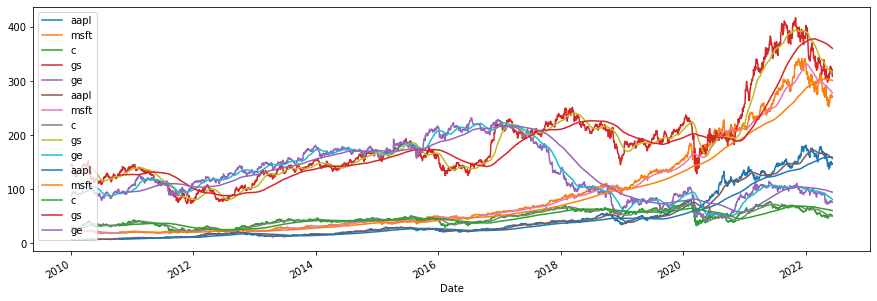

In [6]:

# a rolling mean is a moving average, right?
sma_short = data.rolling(short).mean()
sma_long = data.rolling(long).mean()

# and compute sma_50 for replicating earlier strat
sma_50 = data.rolling(50).mean()

# let's see what the data looks like - this is by no means a pretty chart, but it does the job
plot = bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5))


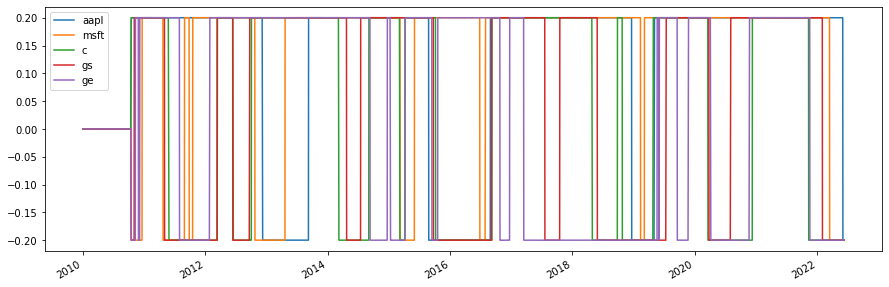

In [7]:
# We need to set up our target weights. This will be the same size as sma_long
# weight = 1 means go long; weight = -1 means short

target_weights = sma_long.copy()


# set appropriate target weights
target_weights[sma_short > sma_long] =  0.2
target_weights[sma_short <= sma_long] = -0.2
# Why are the weights 0.2 and -0.2 (20%) instead of 1 (100%)?


# Now set up the MA_cross strategy for our moving average cross strategy
MA_cross = bt.Strategy('MA_cross', [bt.algos.WeighTarget(target_weights),
                                    bt.algos.Rebalance()])

test_MA = bt.Backtest(MA_cross, data)
res_MA = bt.run(test_MA)

# plot security weights to test logic
res_MA.plot_security_weights()
plt.show()



In [8]:

# define a signal to feed to the SelectWhere class to select securities to trade
# The signal is simple, data>sma_50 because data is price and sma_50 is moving average
signal = data > sma_50



bt.algos.SelectWhere(signal, include_no_data=False)

# first we create the Strategy
s = bt.Strategy('above50sma', [bt.algos.SelectWhere(signal),
                               bt.algos.WeighSpecified(),
                               bt.algos.Rebalance()])

# now we create the Backtest
t = bt.Backtest(s, data)

# and let's run it!
res = bt.run(t, test_MA)

# and some performance stats
res.display()

Stat                 above50sma    MA_cross
-------------------  ------------  ----------
Start                2010-01-03    2010-01-03
End                  2022-06-09    2022-06-09
Risk-free rate       0.00%         0.00%

Total Return         0.00%         85.16%
Daily Sharpe         -             0.37
Daily Sortino        -             0.55
CAGR                 0.00%         5.08%
Max Drawdown         0.00%         -46.09%
Calmar Ratio         -             0.11

MTD                  0.00%         2.20%
3m                   0.00%         5.60%
6m                   0.00%         4.44%
YTD                  0.00%         3.28%
1Y                   0.00%         17.92%
3Y (ann.)            0.00%         6.86%
5Y (ann.)            0.00%         6.71%
10Y (ann.)           0.00%         7.56%
Since Incep. (ann.)  0.00%         5.08%

Daily Sharpe         -             0.37
Daily Sortino        -             0.55
Daily Mean (ann.)    0.00%         6.54%
Daily Vol (ann.)     0.00%         17

<AxesSubplot:title={'center':'Equity Progression'}>

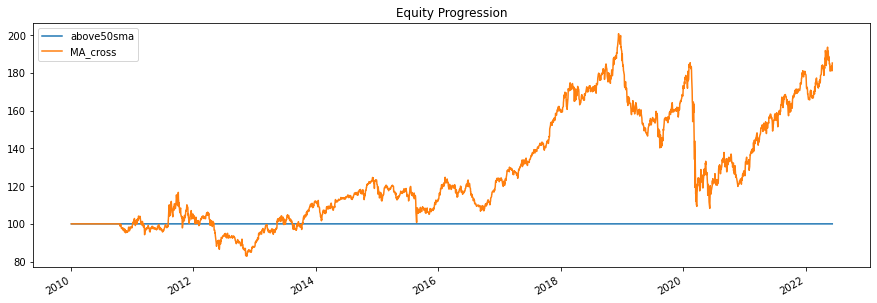

In [9]:

# what does the equity curve look like?
res.plot()


In [10]:
def signal_strategy(strategy_name, signal):
    bt.algos.SelectWhere(signal, include_no_data=False)

    # first we create the Strategy
    s = bt.Strategy('above50sma', [bt.algos.SelectWhere(signal),
                                   bt.algos.WeighSpecified(),
                                   bt.algos.Rebalance()])

    # now we create the Backtest
    t = bt.Backtest(s, data)

    # and let's run it!
    res = bt.run(t, test_MA)

    # and some performance stats
    res.display()

In [11]:
def time_optimizer(short_term, long_term, target_weight_1, target_weight_2):

    # a rolling mean is a moving average, right?
    sma_short = data.rolling(short_term).mean()
    sma_long = data.rolling(long_term).mean()

    # and compute sma_50 for replicating earlier strat
    sma_50 = data.rolling(50).mean()

    # let's see what the data looks like - this is by no means a pretty chart, but it does the job
    #plot = bt.merge(data, sma_short, sma_long).plot(figsize=(15, 5))

    # We need to set up our target weights. This will be the same size as sma_long
    # weight = 1 means go long; weight = -1 means shot_rt

    target_weights = sma_long.copy()


    # set appropriate target weights
    target_weights[sma_short > sma_long] =  target_weight_1
    target_weights[sma_short <= sma_long] = target_weight_2
    # Why are the weights 0.2 and -0.2 (20%) instead of 1 (100%)?


    # Now set up the MA_cross strategy for our moving average cross strategy
    MA_cross = bt.Strategy('MA_cross', [bt.algos.WeighTarget(target_weights),
                                        bt.algos.Rebalance()])

    test_MA = bt.Backtest(MA_cross, data)
    res_MA = bt.run(test_MA)

    # plot security weights to test logic
    #res_MA.plot_security_weights()
    #plt.show()


    # define a signal to feed to the SelectWhere class to select securities to trade
    # The signal is simple, data>sma_50 because data is price and sma_50 is moving average
    signal = data > sma_50
    bt.algos.SelectWhere(signal, include_no_data=False)

    # first we create the Strategy
    s = bt.Strategy('above50sma', [bt.algos.SelectWhere(signal),
                                   bt.algos.WeighSpecified(),
                                   bt.algos.Rebalance()])

    # now we create the Backtest
    t = bt.Backtest(s, data)

    # and let's run it!
    res = bt.run(t, test_MA)
    
    #print(res.stats)

    return round(res.stats.loc['cagr']['MA_cross']*100,2)


In [12]:
print('CAGR ' , time_optimizer(50, 200, 0.2, -0.2))

CAGR  5.08


In [ ]:
short_terms = []
long_terms = []
cagr = []
for long_term in range(150, 250):
    for short_term in range(30, 70):
        print('CAGR for  ', short_term, ' -to- ', long_term, ' - ' , time_optimizer(short_term, long_term, 0.2, -0.2))
        short_terms.append(short_term)
        long_terms.append(long_term)
        cagr.append(time_optimizer(short_term, long_term, 0.2, -0.2))
        print("--------")

CAGR for   30  -to-  150  -  5.14
--------
CAGR for   31  -to-  150  -  4.22
--------
CAGR for   32  -to-  150  -  4.63
--------
CAGR for   33  -to-  150  -  5.61
--------
CAGR for   34  -to-  150  -  6.98
--------
CAGR for   35  -to-  150  -  7.53
--------
CAGR for   36  -to-  150  -  7.52
--------
CAGR for   37  -to-  150  -  7.17
--------
CAGR for   38  -to-  150  -  6.77
--------
CAGR for   39  -to-  150  -  5.99
--------
CAGR for   40  -to-  150  -  6.53
--------
CAGR for   41  -to-  150  -  6.36
--------
CAGR for   42  -to-  150  -  6.48
--------
CAGR for   43  -to-  150  -  6.77
--------
CAGR for   44  -to-  150  -  7.07
--------
CAGR for   45  -to-  150  -  6.57
--------
CAGR for   46  -to-  150  -  6.57
--------
CAGR for   47  -to-  150  -  6.41
--------
CAGR for   48  -to-  150  -  6.44
--------
CAGR for   49  -to-  150  -  6.11
--------
CAGR for   50  -to-  150  -  6.4
--------
CAGR for   51  -to-  150  -  6.44
--------
CAGR for   52  -to-  150  -  6.95
--------
CAGR for   5

CAGR for   61  -to-  154  -  5.53
--------
CAGR for   62  -to-  154  -  5.56
--------
CAGR for   63  -to-  154  -  5.47
--------
CAGR for   64  -to-  154  -  5.3
--------
CAGR for   65  -to-  154  -  5.08
--------
CAGR for   66  -to-  154  -  4.79
--------
CAGR for   67  -to-  154  -  5.21
--------
CAGR for   68  -to-  154  -  5.4
--------
CAGR for   69  -to-  154  -  5.74
--------
CAGR for   30  -to-  155  -  5.95
--------
CAGR for   31  -to-  155  -  5.47
--------
CAGR for   32  -to-  155  -  6.26
--------
CAGR for   33  -to-  155  -  6.87
--------
CAGR for   34  -to-  155  -  8.06
--------
CAGR for   35  -to-  155  -  8.81
--------
CAGR for   36  -to-  155  -  8.51
--------
CAGR for   37  -to-  155  -  8.72
--------
CAGR for   38  -to-  155  -  6.64
--------
CAGR for   39  -to-  155  -  7.24
--------
CAGR for   40  -to-  155  -  7.58
--------
CAGR for   41  -to-  155  -  7.66
--------
CAGR for   42  -to-  155  -  6.76
--------
CAGR for   43  -to-  155  -  6.9
--------
CAGR for   44 

In [ ]:
pd.DataFrame(list(zip(short_terms, long_terms, cagr)),
                 columns=['Short', 'Long', 'CAGR'])